In [21]:
!pip install torch_snippets
!pip install albumentations
from torchsummary import summary
import torchvision.transforms as T
from torch_snippets import *
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import cv2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
data_folder = '/root/'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

cifar10 = torchvision.datasets.CIFAR10(data_folder,train=True,download=True)
data = cifar10.data
target = cifar10.targets

x_train, x_val, y_train, y_val = train_test_split(data,target,test_size=0.2,shuffle=True,random_state=34)
# stratify: prevents an imbalanced class ratio by properly distributing images into training and validation 

# Only 10% labelled data is to be used for training the linear classifier
x_train_10_percent = x_train[:round(len(x_train)*0.1)]
y_train_10_percent = y_train[:round(len(x_train)*0.1)]

Files already downloaded and verified


In [23]:
def get_augmentation(s=1.0):
  color_jitter = A.ColorJitter(contrast=s*0.2,saturation=s*0.2,hue=s*0.2,p=0.8)
  rnd_gray = A.ToGray(p=0.2)
  color_augment = A.Compose([
      color_jitter,
      rnd_gray
  ])
  return color_augment

class CIFAR_Dataset(Dataset):
  def __init__(self,images,targets,mutation=False):
    self.images = images
    self.targets = targets
    self.mutation = mutation
  def __len__(self): return len(self.targets)
  def tensor_normalization(self,image):
    normalize = A.Normalize((0.5,0.5,0.5),
                            (0.5,0.5,0.5))
    to_tensor = ToTensorV2()
    res = A.Compose([
        normalize,
        to_tensor
    ])(image=image)
    return res["image"]
  def augment_image(self,image):
    res = A.RandomResizedCrop(height=224,width=224)(image=image)
    res = get_augmentation(s=1)(image=res["image"])
    return res["image"]
  def __getitem__(self,idx):
    image, target = self.images[idx], self.targets[idx]
    #img = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    img = A.Resize(height=224,width=224)(image=image)
    img = img["image"]
    if self.mutation:
      image1 = self.augment_image(img)
      image1 = self.tensor_normalization(image1)
      image2 = self.augment_image(img)
      image2 = self.tensor_normalization(image2)
      sample = {'image1':image1, 'image2':image2, 'label':target}
    else:
      image = A.Resize(height=224,width=224)(image=img)
      image = self.tensor_normalization(image["image"])
      sample = {'image':image,'label':target}
    return sample

In [24]:
def get_data():
  train = CIFAR_Dataset(x_train_10_percent,y_train_10_percent,mutation=False)
  trn_dl = DataLoader(train,batch_size=125,shuffle=True)

  train_mutation = CIFAR_Dataset(x_train,y_train,mutation=True)
  trn_mutation_dl = DataLoader(train_mutation,batch_size=250,shuffle=True)

  val = CIFAR_Dataset(x_val,y_val,mutation=False)
  val_dl = DataLoader(val,batch_size=125,shuffle=True)
  return trn_dl, trn_mutation_dl, val_dl

trn_dl, trn_mutation_dl, val_dl = get_data()

In [25]:
from torchvision.models import resnet18
from collections import OrderedDict
from copy import deepcopy
resnet = resnet18(pretrained=True)

classifier = nn.Sequential(OrderedDict([
    ('fc1',nn.Linear(resnet.fc.in_features,100)),
    ('added_relu1',nn.ReLU(inplace=True)),
    ('fc2',nn.Linear(100,50)),
    ('added_relu2',nn.ReLU(inplace=True)),
    ('fc3',nn.Linear(50,25))
]))

resnet.fc = classifier
resnet.to(device)

# query, key, queue
resnetq = resnet
resnetk = deepcopy(resnetq)
queue = None

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
tau = 0.05
def loss_fn(q,k,queue):
  N = q.shape[0] # batch size
  C = q.shape[1] # dimensionality of representations

  # bmm = batch matrix multiplication
  # For example, if mat1.shape == [b,n,m] and mat2.shape == [b,m,p], bmm(mat1,mat2).shape == [b,n,p]
  pos = torch.exp(torch.div(torch.bmm(q.view(N,1,C), k.view(N,C,1)).view(N, 1),tau))
  neg = torch.sum(torch.exp(torch.div(torch.mm(q.view(N,C), torch.t(queue)),tau)), dim=1)
  denominator = neg + pos

  return torch.mean(-torch.log(torch.div(pos,denominator)))

In [27]:
# Stacking key embedding to the queue
K = 8192 # a value set for the queue size limitation
flag = 0 # a queue stacking will be stopped when the queue size reaches K and flag is 1
if queue is None:
  while True:
    with torch.no_grad():
      for _, data in enumerate(iter(trn_mutation_dl)):
        xk = data['image2'].to(device)
        k = resnetk(xk).detach()
        k = torch.div(k,torch.norm(k,dim=1).reshape(-1,1))

        if queue is None:
          queue = k
        else:
          if queue.shape[0] < K:
            queue = torch.cat((queue,k),0)
          else:
            flag = 1
        if flag == 1:
          break
    if flag == 1:
      break

EPOCH: 5.000  trn_loss: 0.000  (1025.70s - 0.00s remaining)

100%|██████████| 106/106 [00:00<00:00, 5939.67it/s]


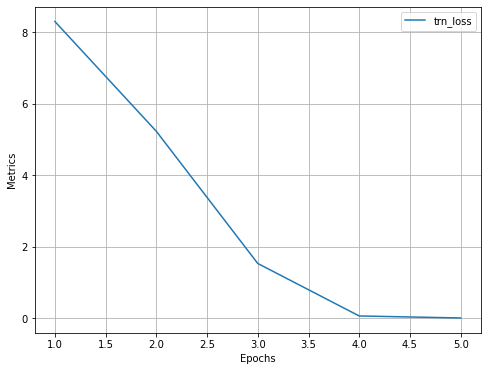

In [28]:
optimizer = optim.SGD(resnetq.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-6)
momentum = 0.999

def train_batch_mutated(batch_ds,queue,resnetq,resnetk,loss_fn,optimizer):
  xq = batch_ds['image1'].to(device)
  xk = batch_ds['image2'].to(device)

  q = resnetq(xq)
  k = resnetk(xk).detach()

  q = torch.div(q,torch.norm(q,dim=1).reshape(-1,1))
  k = torch.div(k,torch.norm(k,dim=1).reshape(-1,1))

  loss = loss_fn(q,k,queue)
  loss.backward()

  optimizer.step()
  optimizer.zero_grad()

  # Update queue if the size reaches its limitation(=K)
  queue = torch.cat((queue,k),dim=0)
  if queue.shape[0] > K:
    queue[250:,:]
  # Update key accordingly using the formula given
  for theta_k, theta_q in zip(resnetk.parameters(),resnetq.parameters()):
    theta_k.data.copy_(momentum*theta_k.data + theta_q.data*(1-momentum))
  return loss.item()

# The cluster visualziation analysis is not needed for this particular example,
# as a relative low batch size is chosen and a small amount of dataset is used.
# If you wish to carry out the visualization analysis, refer to "SimCLR jupyternotebook" in my Github.

n_epochs = 5
log = Report(n_epochs)
for epoch in range(n_epochs):
  N = len(trn_mutation_dl)
  for ix, data in enumerate(iter(trn_mutation_dl)):
    loss = train_batch_mutated(data,queue,resnetq,resnetk,loss_fn,optimizer)
    log.record(epoch+(ix+1)/N,trn_loss=loss,end='\r')
log.plot_epochs(['trn_loss'])

In [29]:
# Remove the last layers (MLP head)
resnetq.fc = nn.Sequential(*list(resnetq.fc.children())[:-3])
resnetq

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
class LinearNet(nn.Module):
  def __init__(self):
    super(LinearNet,self).__init__()
    self.fc1 = torch.nn.Linear(100,10)
  def forward(self,x):
    x = self.fc1(x)
    return x

linear_classifier = LinearNet()
linear_classifier.to(device)
linear_optimizer = optim.SGD(linear_classifier.parameters(),lr=0.1,momentum=0.9,weight_decay=1e-6)
loss_fn = nn.CrossEntropyLoss()

def get_loss(preds,targets):
  loss = loss_fn(preds,targets)
  acc = (torch.max(preds,1)[1]==targets).float().mean()
  return loss, acc

criterion = get_loss

def train_linear_classifier(batch_ds,model,resnet,optimizer,criterion):
  model.train()
  x = batch_ds['image'].to(device)
  y = batch_ds['label'].to(device)
  y_intermediate = resnet(x)
  optimizer.zero_grad()

  y_pred = model(y_intermediate)

  loss, acc = criterion(y_pred,y)
  loss.backward()

  optimizer.step()
  return loss.item(), acc.item()

@torch.no_grad()
def validate_linear_classifier(batch_ds,model,resnet,criterion):
  model.eval()
  x = batch_ds['image'].to(device)
  y = batch_ds['label'].to(device)
  y_intermediate = resnet(x)
  y_pred = model(y_intermediate)
  loss, acc = criterion(y_pred,y)

  return loss.item(), acc.item()

EPOCH: 1.000  val_loss: 1.354  trn_acc: 0.427  trn_loss: 1.590  val_acc: 0.538  (22.69s - 317.70s remaining)
EPOCH: 2.000  val_loss: 0.945  trn_acc: 0.623  trn_loss: 1.084  val_acc: 0.667  (45.40s - 295.12s remaining)
EPOCH: 3.000  val_loss: 0.968  trn_acc: 0.668  trn_loss: 0.950  val_acc: 0.658  (68.00s - 272.01s remaining)
EPOCH: 4.000  val_loss: 0.992  trn_acc: 0.676  trn_loss: 0.910  val_acc: 0.651  (90.40s - 248.60s remaining)
EPOCH: 5.000  val_loss: 0.936  trn_acc: 0.664  trn_loss: 0.932  val_acc: 0.670  (113.02s - 226.03s remaining)
EPOCH: 6.000  val_loss: 0.864  trn_acc: 0.690  trn_loss: 0.883  val_acc: 0.694  (135.54s - 203.31s remaining)
EPOCH: 7.000  val_loss: 0.991  trn_acc: 0.697  trn_loss: 0.856  val_acc: 0.657  (158.03s - 180.60s remaining)
EPOCH: 8.000  val_loss: 0.962  trn_acc: 0.719  trn_loss: 0.813  val_acc: 0.672  (180.63s - 158.05s remaining)
EPOCH: 9.000  val_loss: 0.910  trn_acc: 0.711  trn_loss: 0.800  val_acc: 0.680  (203.05s - 135.36s remaining)
EPOCH: 10.000 

100%|██████████| 116/116 [00:00<00:00, 2796.49it/s]


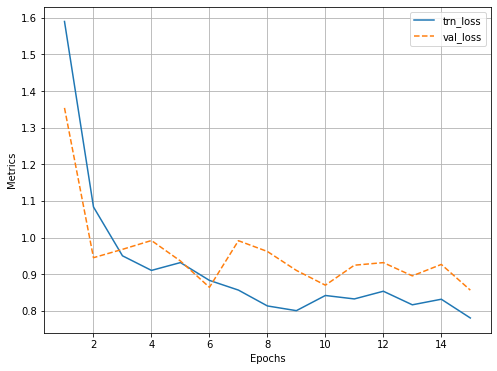

100%|██████████| 116/116 [00:00<00:00, 3177.71it/s]


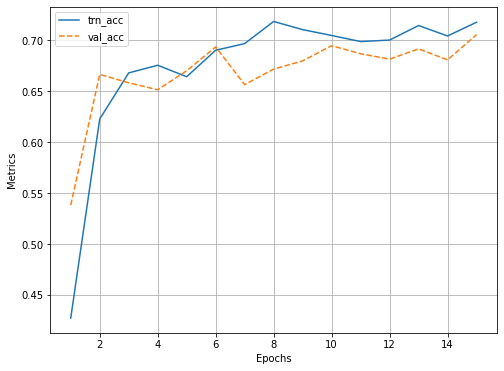

In [31]:
n_epochs = 15
log = Report(n_epochs)
for epoch in range(n_epochs):
  N = len(trn_dl)
  for ix, data in enumerate(iter(trn_dl)):
    loss, acc = train_linear_classifier(data,linear_classifier,resnetq,linear_optimizer,criterion)
    log.record(epoch+(ix+1)/N,trn_loss=loss,trn_acc=acc,end='\r')

  N = len(val_dl)
  for ix, data in enumerate(iter(val_dl)):
    loss, acc = validate_linear_classifier(data,linear_classifier,resnetq,criterion)
    log.record(epoch+(ix+1)/N,val_loss=loss,val_acc=acc,end='\r')
  log.report_avgs(epoch+1)

log.plot_epochs(['trn_loss','val_loss'])
log.plot_epochs(['trn_acc','val_acc'])